**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Neutron Diffusion on a Spherical Domain in Vacuum
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

**Student:** `Melanie Breeze` <br>
**Course:** Engy-4390 Nuclear Systems Design and Analysis  <br>
**Mentor: Valmor F. de Almeida** 

UMass Lowell, Dept. of Chemical Engineering, Nuclear Engineering Program 
<br>
**02Oct2024**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Summary of Parameters](#parameters)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
  + [Analytical Solution](#analyticalsol)
  + [Weak Form of Problem Statement](#weakform)
  + [MOOSE Kernels](#kernels)
  + [Setup](#setup)
    - [One-Group Energy](#onegroupenergy)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

- Introduction to motivation for neutron transport problems

### [Summary of Parameters](#toc)<a id="parameters"></a>



$$
\begin{aligned}
& \text {Table 1. Parameter summary}\\
&\begin{array}{l|c|r}
\hline \hline \text { Parameter } & \text { Definition } & \text { Units } \\
\hline
r & \text{Radius} & \mathrm{cm} \\
r_\mathrm{i} & \text{Inner radius} & \mathrm{cm} \\
r_\mathrm{o} & \text{Outer radius} & \mathrm{cm} \\
\Phi(r) & \text{Neutron scalar flux} & \mathrm{n~cm^{-2}~s^{-1}}  \\
D & \text{Diffusion coefficient} & \mathrm{cm^2~s^{-1}} \\
q & \text{Flux} & ? \\
S & \text{Source term(?)}& \mathrm{g~s^{-1}~cm^{-3}} \\
A & \text{Surface area} & \mathrm{cm^2} \\
V & \text{Volume} & \mathrm{cm^3} \\
\alpha & ? & ? \\
\Sigma & \text{Macroscopic cross section} & \mathrm{cm^{-1}} \\
\Sigma_\mathrm{tot} & \text{Total macroscopic cross section} & \mathrm{cm^{-1}} \\
\Sigma_\mathrm{s} & \text{Macroscopic cross section for scattering} & \mathrm{cm^{-1}} \\
\Sigma_\mathrm{el} & \text{Macroscopic cross section for elastic scattering} & \mathrm{cm^{-1}} \\
\Sigma_\mathrm{non-el} & \text{Macroscopic cross section for non-elastic scattering} & \mathrm{cm^{-1}} \\
\Sigma_\mathrm{abs} & \text{???} & \mathrm{cm^{-1}} \\
\mu & ? & ? \\
\bar{\mu} & ? & ? \\
\Omega & \text{Solid angle} & \mathrm{cm^2~cm^{-2}} \\
Q\mathrm{^{fis}_{ext}} & ? & ? \\
Q\mathrm{^{sc}_{in}} & ? & ? \\
\kappa & \text{Wavenumber} = \frac{2 \pi}{L} & \mathrm{cm^{-1}} \\
L & \text{Wavelength} & \mathrm{cm} \\
v & \text{Velocity} & ? \\
n(r) & ? & ? \\
n_\mathrm{b} & ? & ? \\
\Gamma^\pm & ? & ? \\
J_\mathrm{in} & ? & ? \\
J_\mathrm{out} & ? & ? \\
\hline
\end{array}
\end{aligned}
$$



In [3]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv

## [Problem Statement](#toc)<a id="problem"></a>

### [Strong Form of Problem Statement](#toc)<a id="strongform"></a>

This investigation looks to determine how FEM computation of the neutron diffusion equation compare to linear transport theory given standard assumptions about the definition of the diffusion coefficient in homogenous mediums far from and close to voids. Defining diffusion coefficients for neutron transport is an active field of research and includes approximations such as isotropic scattering, linear in angle, nonlocal weighting of nearby average transport properties, Monte Carlo study and experiment.

Understanding the connection between linear transport theory and diffusion theory is important for analysis of radiative transfer and neutron transport under certain physical conditions for reactor research and dosimetry studies. Here we will compare the analytic linear transport result for non-absorbing and moderately absorbing mediums given a point source in spherical geometry.

The multi-group (energy group) time independent neutron diffusion equation (NDE) in written assuming azimuthal symmetry as

Compute $\Phi_g:[r_\text{i},r_\text{o}]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
  \nabla \cdot D_g \nabla \Phi_g(r) - \Sigma_{g,r} \Phi_g(r) + S_{g'\rightarrow g} &= 0 \\
   q_{n,g}(r_\text{i}) &= A_g, \\
   q_{n,g}(r_\text{o}) &= \frac{\alpha}{2}\Phi_g(r_\text{o}).
\end{align*}

where the source term $S_{g'\rightarrow g} := \sum_{g'=1}^{G} \int_\Omega \Sigma_{s,g'\rightarrow g}\, f_{s,g'\rightarrow g}(\mu)\,d\Omega$ is the group down-scattering contribution for each group $g$.

The neutron scalar flux is: $\Phi(r)\ [n/cm^2 s]$ 

The total macroscopic cross section is: $\Sigma_{tot} = \Sigma_{non-el} + \Sigma_{el} \approx \Sigma_{abs} + \Sigma_{el}$

And the removal cross section for the multi group cross section is $ \Sigma_{r} = \Sigma_{tot} - \bar{\mu}\Sigma_{s} $

For brevity, $S' = Q^{fis}_{ext} + Q^{sc}_{in}$, is written as the combined source for exterior sources and fission sources or scatter in from out of group (up and down scatter). The full _scatter in term_ requires a _group averaged scatter cross section_ that further requires a _transfer function_ differential in post collision direction $\Omega \cdot \Omega '$. 

Here for the free surface (vacuum) boundary condition. The neutron density at the outer boundary $\Phi(r) = |v| n(r) = 0$ if $ n_b\cdot \Omega < 0 $.



### Domain
Describe domain here.

In [1]:
def show_domain(screenshot=False):
    import pyvista as pv
    pv.set_plot_theme('paraview')

    radius_i = 1
    radius_o = 20 * radius_i
    outer = pv.Sphere(center=(0,0,0), direction=(0,0,1), radius=radius_o)
    inner = pv.Sphere(center=(0,0,0), direction=(0,0,1), radius=radius_i)

    plo = pv.Plotter(notebook=True, shape=(1,1)) 
    plo.subplot(0,0)
    plo.add_mesh(outer, color='yellow', opacity=0.99,)
    plo.add_mesh(inner, color='red', opacity=1)
    plo.add_axes(xlabel='R', ylabel='Theta', zlabel='Phi')

    cpos = plo.show(window_size=[800, 600])
    if screenshot:
        plo.screenshot('domain.png')

In [ ]:
show_domain()

/home/melanie/miniconda3/envs/engy/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/melanie/miniconda3/envs/engy/lib/python3.12/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(
ERROR:root:Cannot create GLX context.  Aborting.


## [Objectives](#toc)<a id="obj"></a>

1. Gather Cross Section Data to provide study parameters
2. Set up two analytical solutions
    - Set up the non-asymptotic analytic solution __complete__  
    - Set up the asymptotic analytic solution with transient __almost complete__  
3. Code a MOOSE application to solve the neutron diffusion [problem](#strongform) using Galerkin's method with finite element basis functions
    - Set up spherical coordinate system: __complete__
    - Identify best test functions for problem domain: __unknown__  
    - "Absorption" term $\Sigma_{tot}\Phi $ is causing strong oscillations when included __unknown__  
    

## [Approach](#toc)<a id="app"></a>

### [Analytic Solution](#toc)<a id="analyticalsol"></a> 

A general solution is commonly given without the asymptotic condition as:

\begin{align*}
    \Phi(r) =  \frac{S_0 e^{-\kappa r}}{4\pi Dr} \ \ \ (2)
\end{align*}

On the other hand, linear transport theory does provide a result at the asymptotic limit for moderately absorbing mediums given that the source flux is not infinity. The integral transport equation is written:


\begin{align*}
    \Phi(r) = \int dV\  \frac{S_0 e^{- \Sigma_t r}}{4 \pi r^2} [c \Sigma_t \Phi(r') + S_0 \delta(r')] \ \ \ (3)
\end{align*}

In this solution we will currently assume $S_0 = \Phi_0$ for a single distributed source.

### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 

The Galerkin weak formulation of the [strong form](#strongform) is as follows. Find $\Phi_g \in H^1\!\bigl([r_\text{i},r_\text{o}]\bigr)$ and $u_2 \in H^1\!\bigl([a,b]\bigr)$
so that 

\begin{align*}
\int\limits_a^b D\, u_1'(x)\,w'(x)\,dx - \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), \text{and}
 \\
  \int\limits_a^b v\, u_2'(x)\, w(x)\,dx + \int\limits_a^b D\, u_2'(x)\,w'(x)\,dx + \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr),
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\subset\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty\bigr\}$ and $H^1_0\!\bigl([a,b]\bigr) := \bigl\{ w \mid w \in H^1(a,b), w(a) = 0, w(b) =0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $w$ is called a test function. Because $w$, $u_1$, $u_2$ are sought in very similar sets of functions, this weak form is called Galerkin's weak form.

1. Multiply NDE by a test function $\phi$.
2. Integrate over spatial and angular domain.
3. Use divergence theorem to set the boundary condition across the domain surface.

The weak form and boundary condition becomes:

\begin{align*}
    ( \nabla \phi, D \nabla \Phi  )\ - < \phi, D \nabla \Phi \cdot \bar{n_b} > +\ (\phi , \Sigma_{tot} \Phi) = 0 \ \ \ (1B)
\end{align*}

This weak form contains the volume and surface integral as written with parenthesis and brackets respectively. The boundary conditions for the partial currents at the surface given as $\Gamma^{\pm}$ must be solved for:

\begin{align*}
    \Gamma^{+} = J^{out}({R_S}) = \nabla \Phi \cdot \bar{n_b}
\end{align*}

\begin{align*}
    \Gamma^{-} = J^{in}({R_S}) = 0
\end{align*}

Here we will use the homogenous Neumann boundary condition, which is equivalent to the Robin boundary condition such that the reflectivity at the boundary is 0 as:

\begin{align*}
    \frac{1}{4} \Phi + \frac{1}{2} D \nabla \Phi \cdot \bar{n_b} = J^{-} = \frac{\Phi}{4} - \frac{J}{2} = \frac{\Phi}{4} - \frac{D \nabla \Phi}{2}
\end{align*}

Solving for the weak form boundary condition and multiplying our test function $\phi$:

\begin{align*}
     \phi (D \nabla \Phi \cdot \bar{n_b}) = \phi( \frac{1}{2} D \nabla \Phi)
\end{align*}

#### 2 Group NDE  Weak Form:

Assuming no upscattering from group 2 to group 1:

\begin{align*}
    -\nabla \cdot D_1 \nabla \Phi_1(r)  + \Sigma_{r,1} \Phi(r) =  0 \ \ \ (X) 
\end{align*}

\begin{align*}
    -\nabla \cdot D_2 \nabla \Phi_2(r)  + \Sigma_{r,2} \Phi(r) =  \Sigma_{s,1 \rightarrow 2} \Phi_1(r) \ \ \ (X) 
\end{align*}


/tmp/ipykernel_4831/4196469499.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


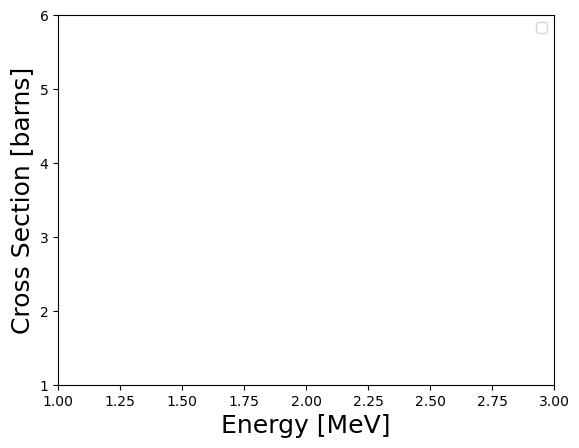

In [1]:
#file2 = np.genfromtxt('./SigTot_Al.csv',delimiter=",",comments = '#')
#file1 = np.genfromtxt('./SigEl_Al.csv',delimiter=",",comments = '#')
import matplotlib.pyplot as plt
plt.xscale("linear")
plt.yscale("linear")
plt.xlim([1, 3])
plt.ylim([1, 6])
plt.xlabel(r'Energy [MeV]', fontsize=18)
plt.ylabel(r'Cross Section [barns]', fontsize=18)
#plt.plot(file1[1:,0]*1e-6, file1[1:,1],label="Elastic Sc. C.S. - Avg. 2.225 b")
#plt.plot(file2[1:,0]*1e-6, file2[1:,1],label="Total Sc. C.S. - Avg. 2.767 b")11
plt.legend()
plt.show()

### [MOOSE Kernels](#toc)<a id="kernels"></a>

The following MOOSE kernels were implemented to solve the [weak form](#weakform):
1. Diffusion term: $D \nabla \Phi \cdot \nabla \phi$
 + [interface](./include/kernels/DiffusionTerm.h) and [implementation](./src/kernels/DiffusionTerm.C).

### [Setup](#toc)<a id="setup"></a>

#### [One-Group Energy](#toc)<a id="onegroupenergy"></a>

## [Results and Analysis](#toc)<a id="ranalysis"></a>

- Text...

In [2]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    #import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(14, 5))

    ax1.plot(df['x'], df['u1'].abs()*2.4e9,'r*-',label=basis_functions_type)

    ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [g/cc]', fontsize=18, color='red')
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    ax1.set_ylim(1e-12,1e12)
    ax1.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

In [3]:
# !./neutron-ball-opt -i input2G.hit
# mooOut1G = np.genfromtxt('./output2G_x-data_0002.csv',delimiter=",",comments = '#')
#!./neutron-ball-opt -i input1G.hit
mooOut1G = np.genfromtxt('./output1G_x-data_0002.csv',delimiter=",",comments = '#')

FileNotFoundError: ./output1G_x-data_0002.csv not found.

In [4]:
#!cat output1G_x-data_0002.csv

In [8]:
#import pandas as pd
df = pd.read_csv('output1G_x-data_0002.csv')
plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Linear Lagrange', flux_basis_functions_type='Constant Monomial')

FileNotFoundError: [Errno 2] No such file or directory: 'output1G_x-data_0002.csv'

## [Conclusions](#toc)<a id="conclusions"></a>

## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5310: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [3] author, [reference]()
- [4] author, [reference]()